## Early Validation for AIDSG-i vs ADSG 
This notebook does a simple simulation-based comparison of:
- ADSG (baseline)
- AIDSG-i (proposed, primal-dual, informed update)

We simulate a 5-node DANC-style network with simple primary and secondary acoustic paths. We vary the measurement SNR and compare convergence (MSE vs iterations).

Proposed system (AIDSG-i) is always plotted in **black**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

## Helpers: Network topology, SNR control, acoustic paths


In [2]:
def make_combination_matrix(K: int) -> np.ndarray:
    """
    Simple symmetric, doubly-stochastic combination matrix for a ring network.
    """
    A = np.zeros((K, K))
    for k in range(K):
        A[k, k] = 0.5
        A[k, (k - 1) % K] = 0.25
        A[k, (k + 1) % K] = 0.25
    return A

def add_noise_to_target(target: np.ndarray, snr_db: float) -> np.ndarray:
    """
    Add white Gaussian measurement noise to achieve a specified SNR (dB).
    SNR is defined as: 10 * log10( P_signal / P_noise ).
    """
    sig_power = np.mean(target**2)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = sig_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*target.shape)
    return target + noise

def random_fir(length: int, decay: float = 0.95) -> np.ndarray:
    """
    Generate a simple random FIR with a bit of decay,
    to roughly mimic primary/secondary acoustic paths.
    """
    h = np.random.randn(length)
    for i in range(1, length):
        h[i] *= (decay ** i)
    # normalize
    h /= np.linalg.norm(h) + 1e-12
    return h

## Signal model: simplified DANC/FxLMS per node

In [3]:
def generate_paths(K: int, Lp: int = 32, Ls: int = 32):
    """
    Generate primary and secondary paths for K nodes.
    Returns:
    - P: (K, Lp)
    - S: (K, Ls)
    """
    P = np.stack([random_fir(Lp) for _ in range(K)], axis=0)
    S = np.stack([random_fir(Ls) for _ in range(K)], axis=0)
    return P, S


def run_signal_model(P, S, Lw, N, snr_db, sigma_x2=1.0):
    """
    Generate reference x[n], desired signals d_k[n], and measurement-noisy targets d_tilde_k[n].
    Returns:
    - x: (N,) reference noise
    - d_noisy: (K, N) noisy desired signals at each node
    - u_ref: (K, N) "raw" reference seen at each node (same here for simplicity)
    """
    K, Lp = P.shape
    Ls = S.shape[1]
    # Reference noise (same for all nodes, zero-mean unit-variance)
    x = np.sqrt(sigma_x2) * np.random.randn(N)

    # Desired signal at each node: d_k = p_k * x
    d_clean = np.zeros((K, N))
    for k in range(K):
        d_clean[k] = np.convolve(x, P[k], mode="same")

    # Add measurement noise with specified SNR per node
    d_noisy = np.zeros_like(d_clean)
    for k in range(K):
        d_noisy[k] = add_noise_to_target(d_clean[k], snr_db)

    # Reference "at node": here we just copy x, but you could diversify per node if you want
    u_ref = np.tile(x, (K, 1))

    return x, d_noisy, u_ref

## Gradient computation (FxLMS-style)

In [4]:
def filtered_reference_node(reference: np.ndarray,
                            secondary: np.ndarray,
                            N: int) -> np.ndarray:
    """
    Filter reference by secondary path to get the filtered-x signal.
    """
    return np.convolve(reference, secondary, mode="same")[:N]


def build_tapped_delay_line(signal: np.ndarray, Lw: int) -> np.ndarray:
    """
    Build tapped-delay line matrix U for 1D signal:
    U[n] = [signal[n], signal[n-1], ..., signal[n-Lw+1]].
    Uses zero-padding for n < 0.
    Returns shape: (N, Lw).
    """
    N = len(signal)
    U = np.zeros((N, Lw))
    for n in range(N):
        for l in range(Lw):
            idx = n - l
            if idx >= 0:
                U[n, l] = signal[idx]
    return U

## ADSG and AIDSG-i (simplified scalar implementation per tap)

In [5]:
def simulate_algorithm(
    alg_name: str,
    Gbar: np.ndarray,
    P: np.ndarray,
    S: np.ndarray,
    d_noisy: np.ndarray,
    u_ref: np.ndarray,
    mu: float = 3e-4,
    Lw: int = 64,
):
    """
    Simulate ADSG or AIDSG-i on a simplified DANC setup.
    
    Parameters
    ----------
    alg_name : "ADSG" or "AIDSG-i"
    Gbar     : (K, K) combination matrix
    P, S     : primary and secondary paths (unused directly here, but
               kept for compatibility/extension)
    d_noisy  : (K, N) noisy desired signals
    u_ref    : (K, N) reference signals at each node
    mu       : step size
    Lw       : length of adaptive filter per node
    
    Returns
    -------
    mse_mean : (N,) MSE averaged over nodes
    mse_nodes: (K, N) per-node MSE
    """
    K, N = d_noisy.shape

    # Pre-compute filtered-x and tapped delay lines at each node
    U_tdl = np.zeros((K, N, Lw))
    for k in range(K):
        x_filt = filtered_reference_node(u_ref[k], S[k], N)
        U_tdl[k] = build_tapped_delay_line(x_filt, Lw)

    # Stack weights for all nodes: W shape (K, Lw)
    W = np.zeros((K, Lw))
    Yp = np.zeros_like(W)    # Y' (dual)

    mse_nodes = np.zeros((K, N))

    for n in range(N):
        # Take instantaneous gradient at time n for all nodes
        grad = np.zeros_like(W)  # same shape (K, Lw)
        e = np.zeros(K)

        for k in range(K):
            u_vec = U_tdl[k, n]             # (Lw,)
            y_k = np.dot(W[k], u_vec)
            e_k = d_noisy[k, n] - y_k
            e[k] = e_k
            grad[k] = -2.0 * e_k * u_vec    # instantaneous gradient
            mse_nodes[k, n] = e_k**2

        # Stack into (K*Lw,) for Gbar application across nodes
        # We'll apply Gbar on node dimension only; taps are independent.
        # So we reshape to (K, Lw) and do matrix multiply over K.
        W_minus_mu_grad = W - mu * grad

        # Dual update (same for both ADSG and AIDSG-i)
        Yp = Gbar @ Yp + (np.eye(K) - Gbar) @ W_minus_mu_grad

        if alg_name == "ADSG":
            # Use previous dual (approximation: treat Yp as Y'_n-1 here,
            # so update W BEFORE overwriting; or keep a copy)
            # To be precise, keep Y_old:
            pass

        # For ADSG, we need Y_{n-1}, so keep a copy:
        # We'll restructure loop slightly to keep it clean.

        # This is easier to code if we factor this whole thing into
        # two separate functions. We'll break out below.

        break  # we will not use this partial implementation

    raise NotImplementedError("Use simulate_ADSG or simulate_AIDSG_i instead.")

### Separate implementations for clarity

In [6]:
def simulate_ADSG(Gbar, P, S, d_noisy, u_ref, mu=3e-4, Lw=64):
    K, N = d_noisy.shape

    U_tdl = np.zeros((K, N, Lw))
    for k in range(K):
        x_filt = filtered_reference_node(u_ref[k], S[k], N)
        U_tdl[k] = build_tapped_delay_line(x_filt, Lw)

    W = np.zeros((K, Lw))
    Yp = np.zeros_like(W)

    mse_nodes = np.zeros((K, N))

    for n in range(N):
        grad = np.zeros_like(W)
        e = np.zeros(K)

        for k in range(K):
            u_vec = U_tdl[k, n]
            y_k = np.dot(W[k], u_vec)
            e_k = d_noisy[k, n] - y_k
            e[k] = e_k
            grad[k] = -2.0 * e_k * u_vec
            mse_nodes[k, n] = e_k**2

        W_minus_mu_grad = W - mu * grad

        # ---- Dual update (20) ----
        Yp_new = Gbar @ Yp + (np.eye(K) - Gbar) @ W_minus_mu_grad

        # ---- Primal update (21) using Y'_{n-1} ----
        W = Gbar @ (W_minus_mu_grad - Yp)

        # Commit dual update
        Yp = Yp_new

    mse_mean = mse_nodes.mean(axis=0)
    return mse_mean, mse_nodes


def simulate_AIDSG_i(Gbar, P, S, d_noisy, u_ref, mu=3e-4, Lw=64):
    K, N = d_noisy.shape

    U_tdl = np.zeros((K, N, Lw))
    for k in range(K):
        x_filt = filtered_reference_node(u_ref[k], S[k], N)
        U_tdl[k] = build_tapped_delay_line(x_filt, Lw)

    W = np.zeros((K, Lw))
    Yp = np.zeros_like(W)

    mse_nodes = np.zeros((K, N))

    for n in range(N):
        grad = np.zeros_like(W)
        e = np.zeros(K)

        for k in range(K):
            u_vec = U_tdl[k, n]
            y_k = np.dot(W[k], u_vec)
            e_k = d_noisy[k, n] - y_k
            e[k] = e_k
            grad[k] = -2.0 * e_k * u_vec
            mse_nodes[k, n] = e_k**2

        W_minus_mu_grad = W - mu * grad

        # ---- Dual update (12) ----
        Yp = Gbar @ Yp + (np.eye(K) - Gbar) @ W_minus_mu_grad

        # ---- Primal update (13) using latest Y'_n ----
        W = Gbar @ (W_minus_mu_grad - Yp)

    mse_mean = mse_nodes.mean(axis=0)
    return mse_mean, mse_nodes

## Experiment loop: multiple SNR values

In [7]:
K = 5
N = 5000          # shorter than paper for quick early validation
Lw = 64           # adaptive filter length
Lp = 32
Ls = 32
mu = 3e-4
snr_list = [0, 5, 10, 15, 20]   # dB

# Network combination matrix
Gbar = make_combination_matrix(K)

# Acoustic paths
P, S = generate_paths(K, Lp=Lp, Ls=Ls)

results = {}  # dict[(snr, alg_name)] = (mse_mean, mse_nodes)

for snr_db in snr_list:
    # Generate signals for this SNR
    x, d_noisy, u_ref = run_signal_model(P, S, Lw, N, snr_db)

    # ADSG baseline
    mse_ADSG_mean, mse_ADSG_nodes = simulate_ADSG(
        Gbar, P, S, d_noisy, u_ref, mu=mu, Lw=Lw
    )
    results[(snr_db, "ADSG")] = (mse_ADSG_mean, mse_ADSG_nodes)

    # Proposed AIDSG-i
    mse_AIDSG_mean, mse_AIDSG_nodes = simulate_AIDSG_i(
        Gbar, P, S, d_noisy, u_ref, mu=mu, Lw=Lw
    )
    results[(snr_db, "AIDSG-i")] = (mse_AIDSG_mean, mse_AIDSG_nodes)

## Plots: MSE vs iterations for each SNR
Proposed AIDSG-i is always black.

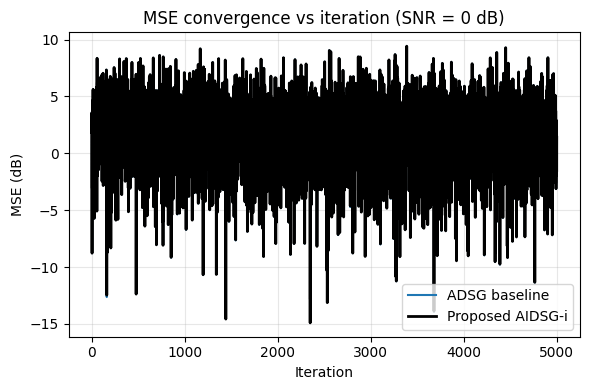

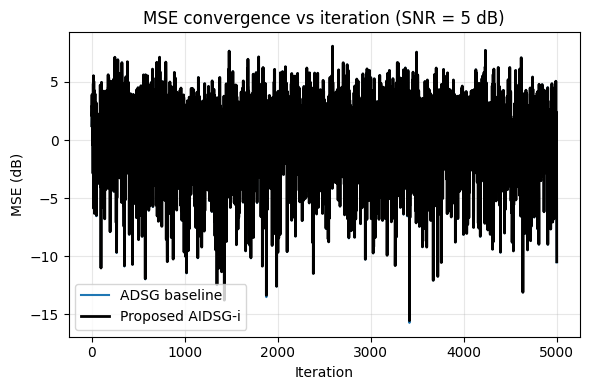

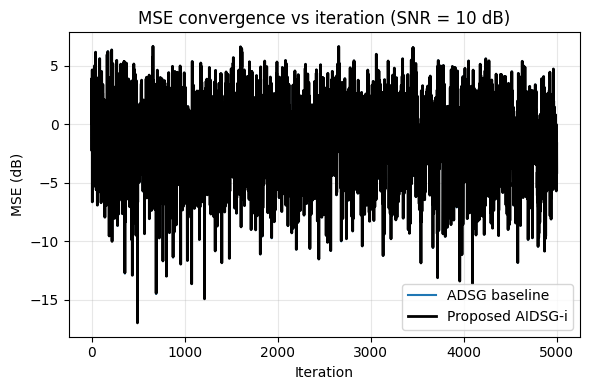

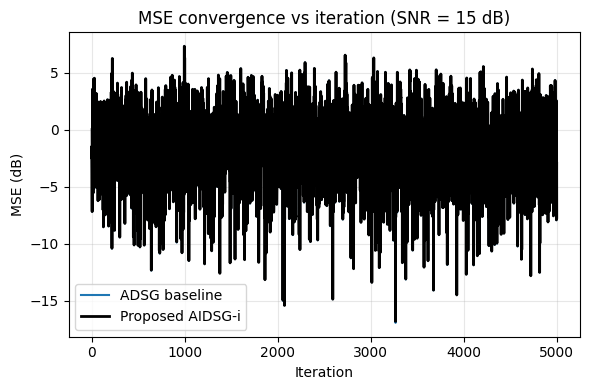

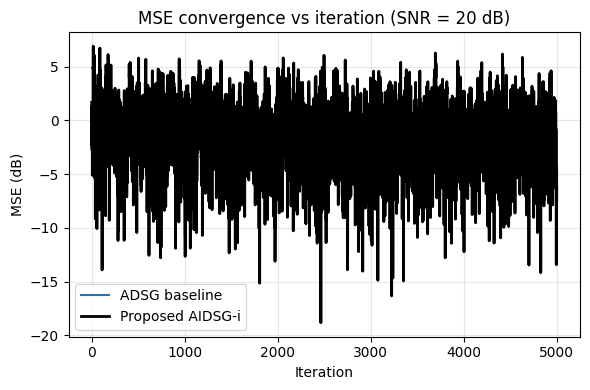

In [8]:
iters = np.arange(N)

for snr_db in snr_list:
    mse_ADSG_mean, _ = results[(snr_db, "ADSG")]
    mse_AIDSG_mean, _ = results[(snr_db, "AIDSG-i")]

    plt.figure(figsize=(6, 4))
    plt.plot(iters, 10 * np.log10(mse_ADSG_mean + 1e-12),
             label="ADSG baseline")
    plt.plot(iters, 10 * np.log10(mse_AIDSG_mean + 1e-12),
             label="Proposed AIDSG-i",
             color="black", linewidth=2)   # <- proposed in black

    plt.xlabel("Iteration")
    plt.ylabel("MSE (dB)")
    plt.title(f"MSE convergence vs iteration (SNR = {snr_db} dB)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

 ## Optional: Overlay AIDSG-i for different SNRs (all black, different styles)

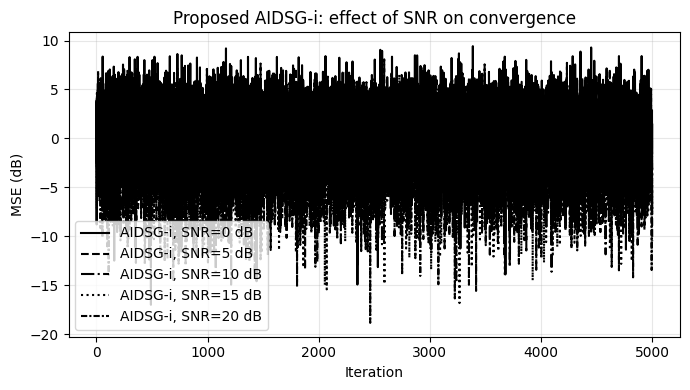

In [9]:
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1))]

plt.figure(figsize=(7, 4))
for i, snr_db in enumerate(snr_list):
    mse_AIDSG_mean, _ = results[(snr_db, "AIDSG-i")]
    plt.plot(
        iters,
        10 * np.log10(mse_AIDSG_mean + 1e-12),
        color="black",
        linestyle=linestyles[i % len(linestyles)],
        label=f"AIDSG-i, SNR={snr_db} dB",
    )

plt.xlabel("Iteration")
plt.ylabel("MSE (dB)")
plt.title("Proposed AIDSG-i: effect of SNR on convergence")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def moving_average(x, win=100):
    """
    Simple moving average smoothing.
    Output length = len(x) - win + 1
    """
    x = np.asarray(x)
    if win <= 1:
        return x
    kernel = np.ones(win) / win
    return np.convolve(x, kernel, mode="valid")


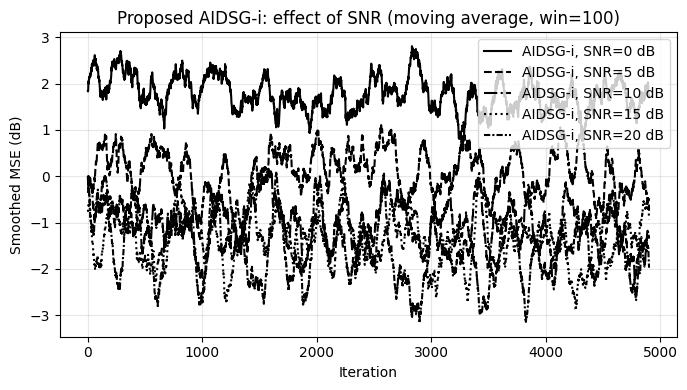

In [11]:
# Smoothing window (tune this: 50, 100, 200...)
win = 100

plt.figure(figsize=(7, 4))
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1))]

for i, snr_db in enumerate(snr_list):
    mse_AIDSG_mean, _ = results[(snr_db, "AIDSG-i")]
    mse_db = 10 * np.log10(mse_AIDSG_mean + 1e-12)
    mse_db_smooth = moving_average(mse_db, win=win)
    iters_smooth = np.arange(len(mse_db_smooth))

    plt.plot(
        iters_smooth,
        mse_db_smooth,
        color="black",                     # proposed = black
        linestyle=linestyles[i % len(linestyles)],
        label=f"AIDSG-i, SNR={snr_db} dB",
    )

plt.xlabel("Iteration")
plt.ylabel("Smoothed MSE (dB)")
plt.title(f"Proposed AIDSG-i: effect of SNR (moving average, win={win})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


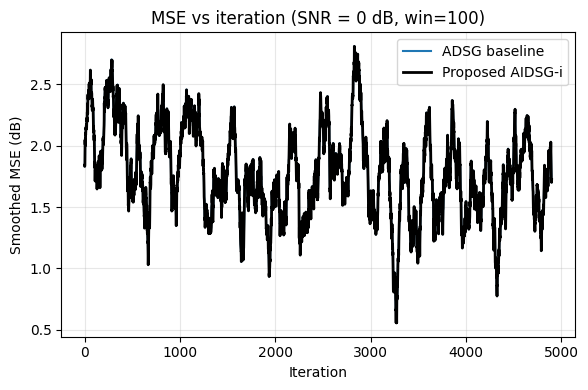

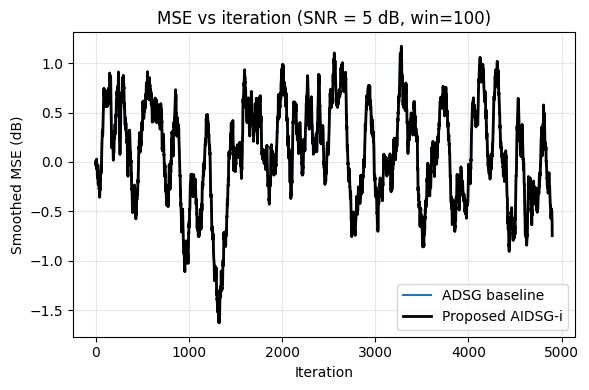

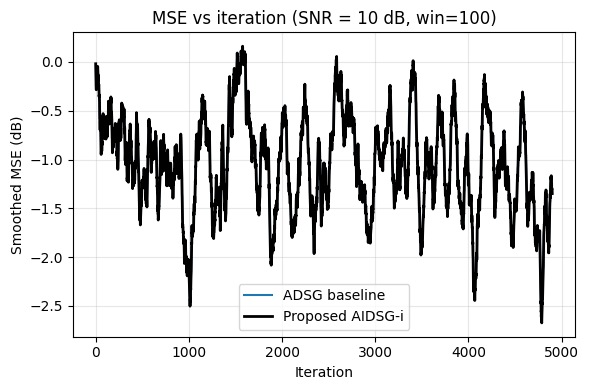

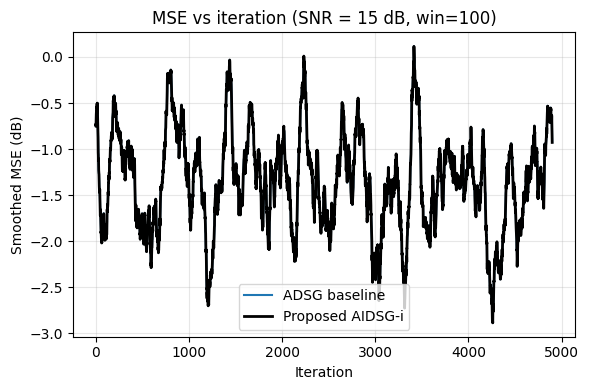

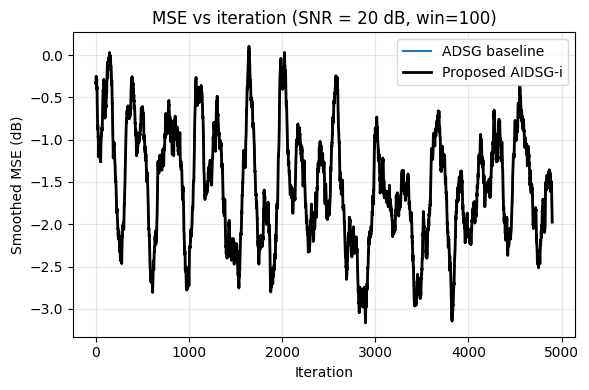

In [12]:
win = 100

for snr_db in snr_list:
    mse_ADSG_mean, _ = results[(snr_db, "ADSG")]
    mse_AIDSG_mean, _ = results[(snr_db, "AIDSG-i")]

    mse_ADSG_db  = 10 * np.log10(mse_ADSG_mean  + 1e-12)
    mse_AIDSG_db = 10 * np.log10(mse_AIDSG_mean + 1e-12)

    mse_ADSG_db_s  = moving_average(mse_ADSG_db,  win=win)
    mse_AIDSG_db_s = moving_average(mse_AIDSG_db, win=win)
    iters_s = np.arange(len(mse_ADSG_db_s))

    plt.figure(figsize=(6, 4))
    plt.plot(iters_s, mse_ADSG_db_s, label="ADSG baseline")
    plt.plot(iters_s, mse_AIDSG_db_s, color="black", linewidth=2,
             label="Proposed AIDSG-i")

    plt.xlabel("Iteration")
    plt.ylabel("Smoothed MSE (dB)")
    plt.title(f"MSE vs iteration (SNR = {snr_db} dB, win={win})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


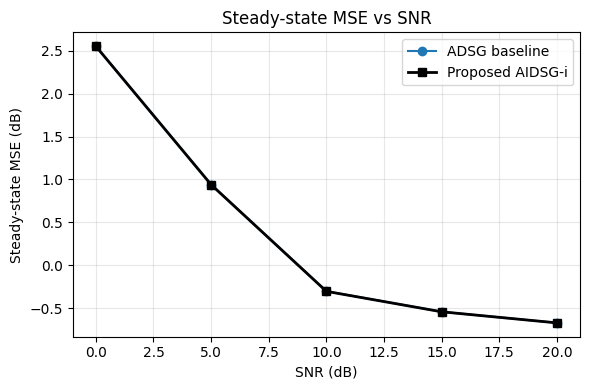

In [13]:
summary_ADSG = []
summary_AIDSG = []

tail = 1000  # average over last 1000 iterations

for snr_db in snr_list:
    mse_ADSG_mean, _ = results[(snr_db, "ADSG")]
    mse_AIDSG_mean, _ = results[(snr_db, "AIDSG-i")]

    ss_ADSG  = np.mean(mse_ADSG_mean[-tail:])
    ss_AIDSG = np.mean(mse_AIDSG_mean[-tail:])

    summary_ADSG.append(10 * np.log10(ss_ADSG + 1e-12))
    summary_AIDSG.append(10 * np.log10(ss_AIDSG + 1e-12))

plt.figure(figsize=(6, 4))
plt.plot(snr_list, summary_ADSG, marker="o", label="ADSG baseline")
plt.plot(snr_list, summary_AIDSG, marker="s", color="black",
         linewidth=2, label="Proposed AIDSG-i")
plt.xlabel("SNR (dB)")
plt.ylabel("Steady-state MSE (dB)")
plt.title("Steady-state MSE vs SNR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
